In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import tensorflow as tf
tf.test.gpu_device_name() # Check GPU is active or not

''

In [4]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

# Import Libraries

In [5]:
import os
import tarfile
import shutil
import csv
import time
from xml.etree import ElementTree as ET
import pandas as pd
import string
import re
from nltk.corpus import stopwords
from nltk import  word_tokenize
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from keras.preprocessing.text import Tokenizer
from collections import Counter
from keras.utils import pad_sequences,to_categorical
from wordcloud import WordCloud
import pickle
from keras.applications import xception
from keras.models import Model,load_model
from keras.utils import load_img, img_to_array
import time
import warnings
warnings.filterwarnings('ignore')
sns.set_theme(palette='Spectral')
tf.config.run_functions_eagerly(True)

# Useful Functions for EDA and Create Final Dataset

In [6]:
def download_dataset(root_filepath:str):
    print("try to download dataset...")
    dataset_fp = os.path.join(root_filepath,"dataset")
    if not os.path.exists(dataset_fp):
        print("dataset folder created")
        os.mkdir(dataset_fp)
    else:
        reports_tgz = os.path.join(root_filepath,"NLMCXR_reports.tgz")
        if not os.path.exists(reports_tgz):
            reports_fp = os.path.join(dataset_fp,"reports")
            os.mkdir(reports_fp)
            os.system(f"wget -P {root_filepath} https://openi.nlm.nih.gov/imgs/collections/NLMCXR_reports.tgz")
            time.sleep(1)
            shutil.move(src=reports_tgz,dst=os.path.join(reports_fp,"NLMCXR_reports.tgz"))
        else:
            print("Reports files are already exist")

        images_tgz= os.path.join(root_filepath,"NLMCXR_png.tgz")
        if not os.path.exists(images_tgz):
            images_fp = os.path.join(dataset_fp,"images")
            os.mkdir(images_fp)
            os.system(f"wget -P {root_filepath} https://openi.nlm.nih.gov/imgs/collections/NLMCXR_png.tgz")
            time.sleep(1)
            shutil.move(src=images_tgz,dst=os.path.join(images_fp,"NLMCXR_png.tgz"))
        else:
            print("Image files are already exist")

def extract_tarfile(source_filepath:str, destination_filepath:str):
    print("extract function is worked.")
    if len(os.listdir(destination_filepath)) == 0:
        print("extracting\nFrom ",source_filepath, "\nTo:",destination_filepath)
        tar = tarfile.open(source_filepath, 'r')
        for item in tar:
            tar.extract(item, destination_filepath)
            if item.name.find(".tgz") != -1 or item.name.find(".tar") != -1:
                extract(item.name, "./" + item.name[:item.name.rfind('/')])
    else:
        print("no need extract for ",destination_filepath)

def convert_xml_to_csv(source_filepath:str,destination_filepath:str):
    print("Converting XML files to CSV...")
    columns = ["ID", "FINDING"]
    if not os.path.exists(destination_filepath):
      # create file
      with open(destination_filepath, 'w', encoding='utf-8') as f:
          csv.writer(f).writerow(columns)
          print("Created file as ",destination_filepath)

      # fill rows
      with open(destination_filepath, 'a', encoding='utf-8') as f:
          for curr_file in os.listdir(source_filepath):
              if curr_file.endswith('.xml'):
                  filepath = os.path.join(source_filepath,curr_file)
                  tree = ET.parse(filepath)
                  root = tree.getroot()
                  findings = root.find('./MedlineCitation/Article/Abstract/AbstractText[@Label="FINDINGS"]')
                  finding = "No Findings" if findings.text is None else findings.text
                  img_ids = [list(img.attrib.values())[0] for img in root.iter() if img.tag == 'parentImage']
                  for img_id in img_ids:
                      row = [img_id, finding]
                      csv.writer(f).writerow(row)
    else:
      print(destination_filepath," is already exist.")


def decontraction(sentence):
    sentence = re.sub(r"won't", "will not", sentence)
    sentence = re.sub(r"can\'t", "can not", sentence)
    sentence = re.sub(r"n\'t", " not", sentence)
    sentence = re.sub(r"\'re", " are", sentence)
    sentence = re.sub(r"\'s", " is", sentence)
    sentence = re.sub(r"\'d", " would", sentence)
    sentence = re.sub(r"\'ll", " will", sentence)
    sentence = re.sub(r"\'t", " not", sentence)
    sentence = re.sub(r"\'ve", " have", sentence)
    sentence = re.sub(r"\'m", " am",sentence)
    sentence = re.sub(r"n\'t", " not", sentence)
    sentence = re.sub(r"\'re", " are", sentence)
    sentence = re.sub(r"\'s", " is", sentence)
    sentence = re.sub(r"\'d", " would", sentence)
    sentence = re.sub(r"\'ll", " will", sentence)
    sentence = re.sub(r"\'t", " not", sentence)
    sentence = re.sub(r"\'ve", " have",sentence)
    sentence = re.sub(r"\'m", " am", sentence)
    sentence = re.sub(r"\*+", "abuse", sentence)
    return sentence

def remove_stopwords(sentence:str):
    all_stopwords = stopwords.words('english')
    all_stopwords.remove('not')# removing the "not" from the stopwords
    all_stopwords.remove('no')
    text_tokens = word_tokenize(sentence) # tokenizing the sentence into word
    tokens_without_sw = [word for word in text_tokens if not word in all_stopwords]
    return " ".join(tokens_without_sw)

def add_start_stop_token(sentence:str):
    sentence = f"<start> {sentence} <end>"
    return sentence

def to_text_preprocess(data) -> list:
    clean_finding = []

    for sentence in data:
        sentence = sentence.lower()# making the text in lower case
        sentence.translate(str.maketrans('', '', string.punctuation))
        sentence = re.sub(r"[|\'||\\||/|?|$|.|.|,||;|><!&)(:`\n\t@#=+%^*~-]","",sentence)# removing the special character in text
        sentence = re.sub(r"xxxx","",sentence)# Removing the irrelavent XXXX words
        sentence = re.sub(r'xxx',"",sentence)
        sentence = re.sub(r'xx',"",sentence)
        sentence = re.sub(r'[0-9]',"",sentence)# Removing the number in text
        sentence = re.sub(r"yearold", "", sentence)
        sentence = re.sub('\s+',' ',sentence)
        sentence = re.sub("'",'',sentence)# Removing apoustahe
        sentence = re.sub(r'\.\.+', '.',sentence)# Removing multiple full stop
        sentence = re.sub(r'  ',"",sentence)
        sentence = decontraction(sentence)
        sentence = remove_stopwords(sentence)

        sentence = add_start_stop_token(sentence)
        clean_finding.append(sentence)

    return clean_finding


def calculate_iqr(df:pd.DataFrame,col:str,q1_ratio:float,q3_ratio:float):
    q1 = df[col].quantile(q1_ratio)
    q3 = df[col].quantile(q3_ratio)
    print("q3:",q3,"\tq1:",q1)
    iqr = q3 - q1
    up_limit = round(q3 + (1.5 * iqr))
    low_limit = round(q1 - (1.5 * iqr))
    low_limit =  0 if low_limit <0 else low_limit
    df_is_upper = df[df[col] > up_limit]
    df_is_lower = df[df[col] < low_limit]
    print("Up limit:",up_limit,"\tLow limit:",low_limit)
    print("Anomalies: Upper:",df_is_upper.shape,"\tLower:",df_is_lower.shape)
    return up_limit,low_limit


def remove_outliers(df,col,q1_ratio=.25,q3_ratio=.75):
    df_temp  = df.copy()
    df_temp[col] = df_temp["CLEAN_FINDING"].apply(lambda row:len(row.split()))
    up_limit,low_limit= calculate_iqr(df_temp,col,q1_ratio,q3_ratio)
    df_temp = df_temp[(df_temp[col] < up_limit) & (df_temp[col] > low_limit )]
    print("final df shape:",df_temp.shape)
    return df_temp


def plot_unique_values(data,bar_title):
    total = data.count()
    uniqAll = data.nunique()
    uniqAndOnlyOnce = np.sum(data.value_counts() == 1)
    uniqAndManyTimes = np.sum(data.value_counts() > 1)
    y = ['Total Findings','Total Unique Findings','Only Once Unique','Many times used in Unique']
    X = [total,uniqAll,uniqAndOnlyOnce,uniqAndManyTimes]
    plt.figure(figsize=(6,3))
    plt.title(bar_title)
    ax = sns.barplot(x=X,y=y)
    ax.bar_label(ax.containers[0])


def plot_most_values(data,bar_title):
    X = data.value_counts()[:10].values
    y = data.value_counts()[:10].keys()
    plt.figure(figsize=(3,12))
    plt.title(bar_title)
    ax = sns.barplot(x=X,y=y)
    ax.bar_label(ax.containers[0])


def save_pkl(data,filepath):
    with open(filepath,'wb') as f:
      pickle.dump(data,f)
      print("file saved as ",filepath)

def load_pkl(filepath):
    with open(filepath,"rb") as f:
      data = pickle.load(f)
      print("file load from ",filepath)
      return data


def extract_an_image_feature(model,img_root_path:str,img_id:str) -> np.ndarray:
    img_path = img_id if img_id.endswith('.png') else img_id + '.png'
    img_path = os.path.join(img_root_path, img_path)
    img_dim = model.input_shape[1:3]
    img = load_img(img_path, target_size=img_dim)
    img = img_to_array(img)
    w, h, ch = img.shape[0], img.shape[1], img.shape[2]
    img = img.reshape((1, w, h, ch))

    if model.name == 'xception':
        img = xception.preprocess_input(img)
    else:
        raise Exception("undefined model name")

    feature = model.predict(img, verbose=0)
    return feature

# Download data & Prepare for Mining

In [7]:
# Define filepaths
root_filepath = "/content/drive/MyDrive/ChestXAI"
image_filepath = "/content/drive/MyDrive/ChestXAI/dataset/images"
reports_filepath = "/content/drive/MyDrive/ChestXAI/dataset/reports"
dataset_filepath = "/content/drive/MyDrive/ChestXAI/dataset"
models_filepath = "/content/drive/MyDrive/ChestXAI/models"

# Download dataset for images and reports
download_dataset(root_filepath=root_filepath)
extract_tarfile(source_filepath=os.path.join(dataset_filepath,"NLMCXR_png.tgz"),destination_filepath=image_filepath)
extract_tarfile(source_filepath=os.path.join(dataset_filepath,"NLMCXR_reports.tgz"),destination_filepath=reports_filepath)
convert_xml_to_csv(source_filepath=os.path.join(reports_filepath,"ecgen-radiology"),destination_filepath=os.path.join(reports_filepath,"reports.csv"))


try to download dataset...
Reports files are already exist
Image files are already exist
extract function is worked.
no need extract for  /content/drive/MyDrive/ChestXAI/dataset/images
extract function is worked.
no need extract for  /content/drive/MyDrive/ChestXAI/dataset/reports
Converting XML files to CSV...
/content/drive/MyDrive/ChestXAI/dataset/reports/reports.csv  is already exist.


## Preprocess Reports (Findings)

In [105]:
df_reports_raw = pd.read_csv(os.path.join(reports_filepath,"reports.csv"))
img_filenames = list(set([el.split('.png')[0] for el in os.listdir(image_filepath)]))
df_reports = df_reports_raw.copy()
df_reports = df_reports[df_reports["ID"].isin(img_filenames)] # Select existed images
df_reports["CLEAN_FINDING"] = to_text_preprocess(data=df_reports_raw["FINDING"].values) # Preprocess Findings
df_reports = remove_outliers(df=df_reports,col="WORD_COUNT",q1_ratio=.30,q3_ratio=.70) # Remove Outliers for Findings

q3: 26.0 	q1: 16.0
Up limit: 41 	Low limit: 1
Anomalies: Upper: (283, 4) 	Lower: (0, 4)
final df shape: (7159, 4)


## Visualize & EDA on Findings

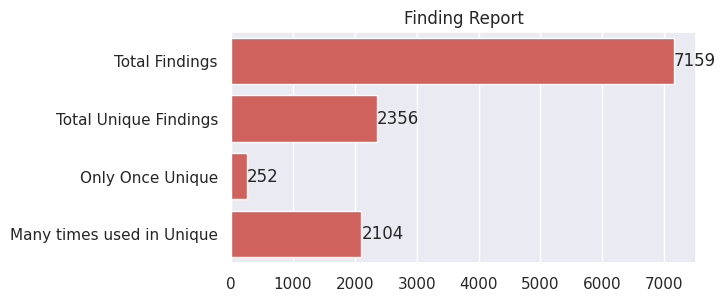

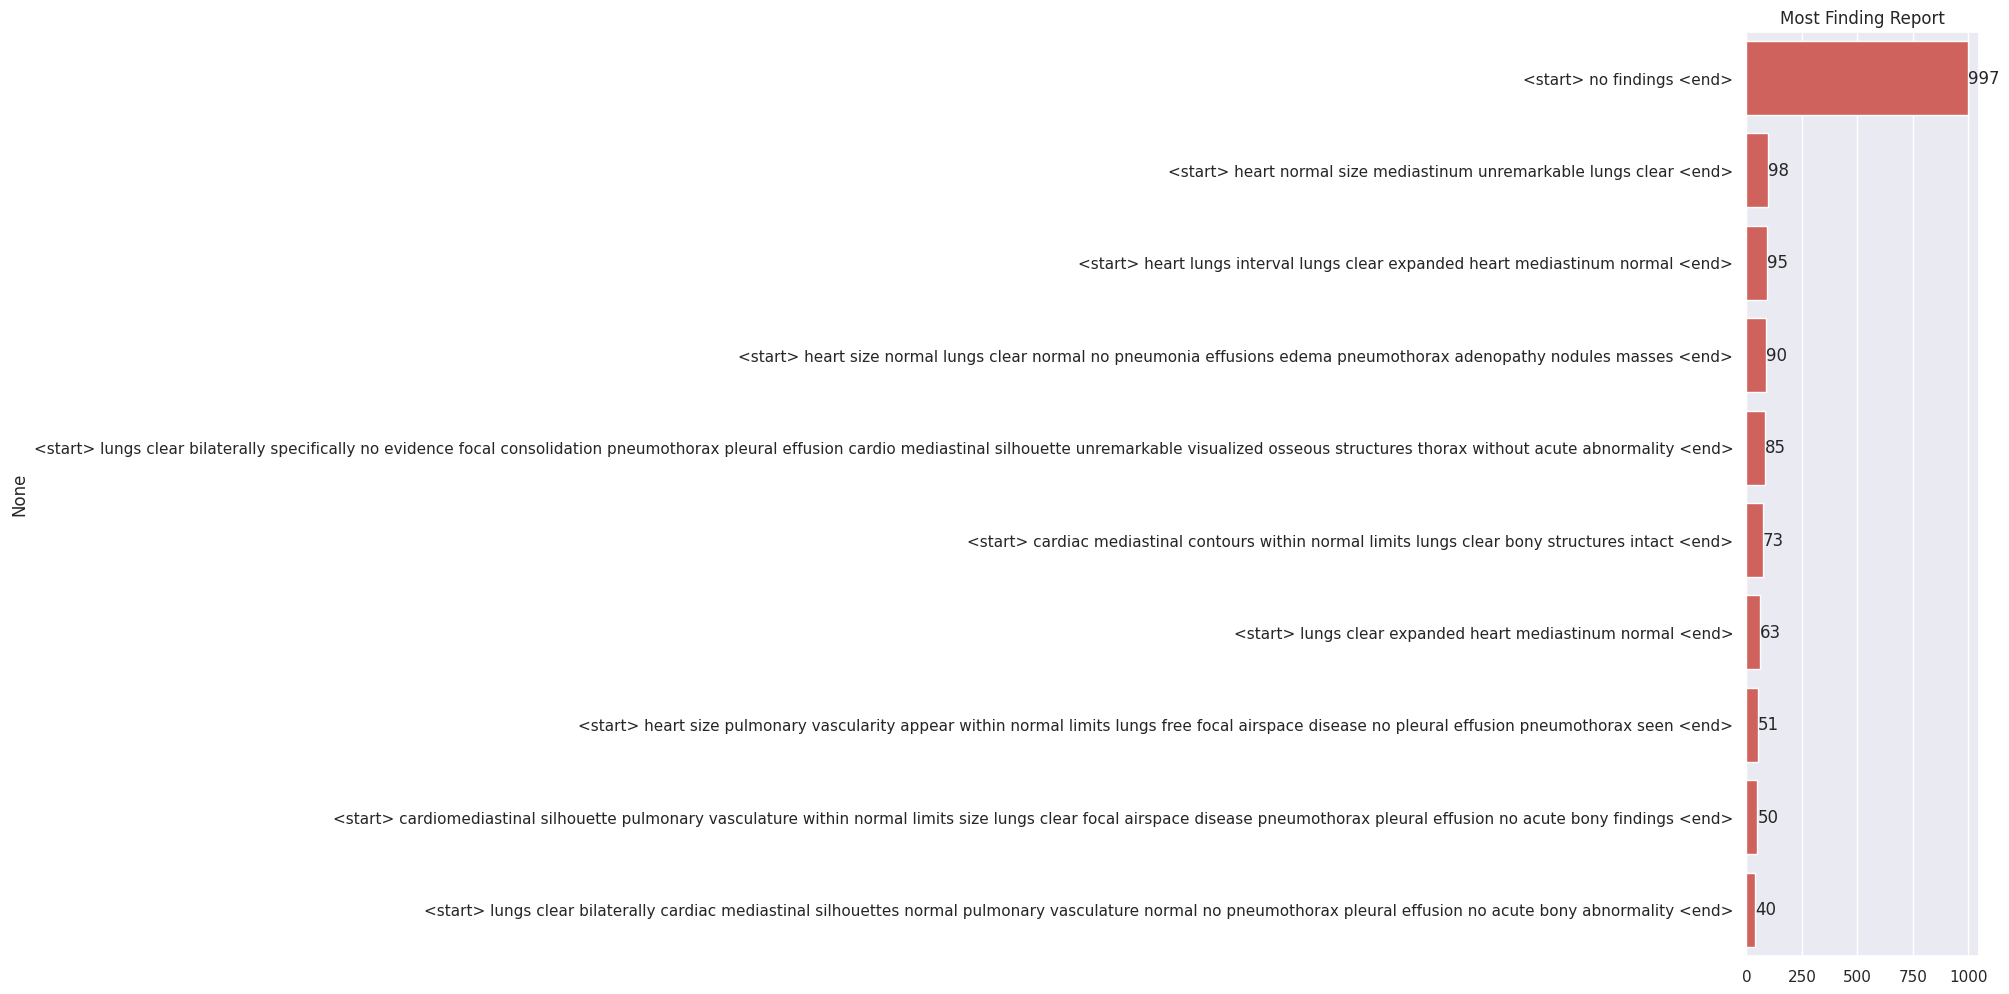

In [106]:
plot_unique_values(df_reports["CLEAN_FINDING"],bar_title='Finding Report')
plot_most_values(df_reports["CLEAN_FINDING"],bar_title="Most Finding Report")

<Axes: ylabel='WORD_COUNT'>

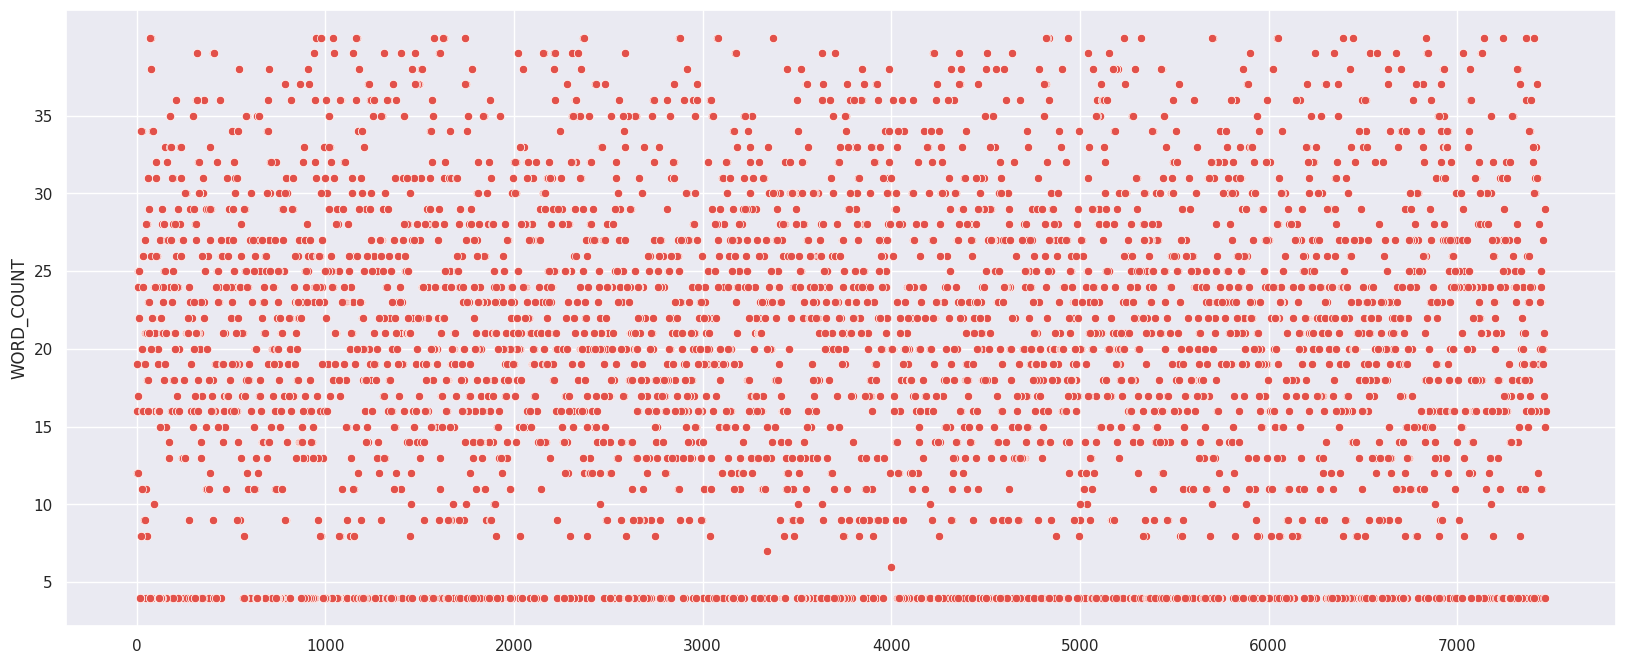

In [107]:
plt.figure(figsize=(20,8))
data = df_reports.sort_values('WORD_COUNT')["WORD_COUNT"]
plt.yticks(np.arange(0,max(data.values),5))
sns.scatterplot(data)

## Create Tokenizer
- Vocabulary
- Vocabsize
- Max. Sequence Length

In [108]:
tokenizer = Tokenizer(oov_token="<unk>")
tokenizer.fit_on_texts(df_reports.CLEAN_FINDING.unique().tolist())

captions_sequences = tokenizer.texts_to_sequences(df_reports.CLEAN_FINDING.values)
captions_vector =  pad_sequences(captions_sequences, padding='post')
VOCABSIZE = len(tokenizer.word_index)+1
SEQ_LENGTH = len(captions_vector[0])
print("VOCABSIZE:",VOCABSIZE,"\tSEQ_LENGTH:",SEQ_LENGTH)

VOCABSIZE: 1388 	SEQ_LENGTH: 40


## More Analysis on Words and Sentences

[Text(0, 0, '3203'),
 Text(0, 0, '2358'),
 Text(0, 0, '2356'),
 Text(0, 0, '2332'),
 Text(0, 0, '1766'),
 Text(0, 0, '1709'),
 Text(0, 0, '1616'),
 Text(0, 0, '1476'),
 Text(0, 0, '1356'),
 Text(0, 0, '1253'),
 Text(0, 0, '1196'),
 Text(0, 0, '972'),
 Text(0, 0, '942'),
 Text(0, 0, '905'),
 Text(0, 0, '823')]

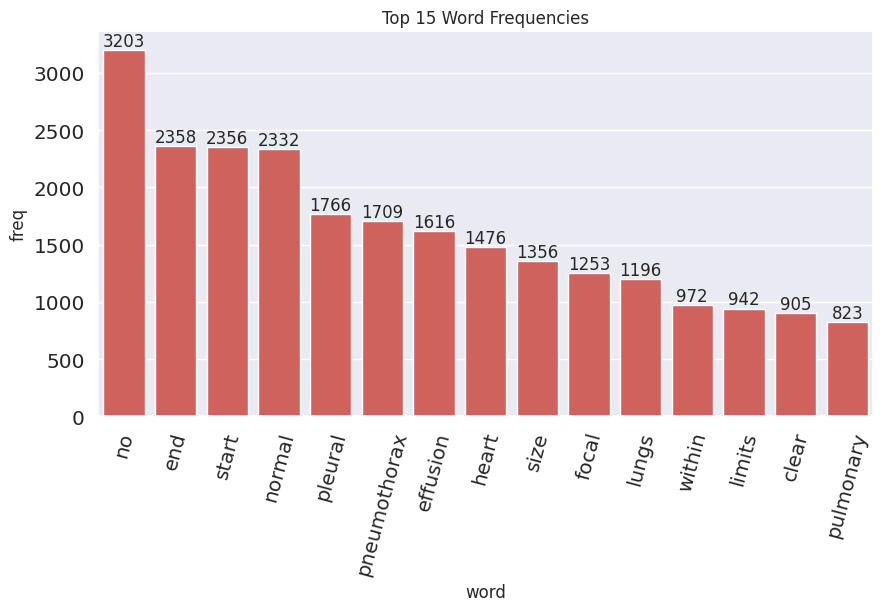

In [11]:
words = sorted(tokenizer.word_counts.items(),key=lambda x:x[1],reverse=True)
most_15_words = words[:15]
df_word = pd.DataFrame.from_records([{'word':data[0],'freq':data[1]}
                                     for data in most_15_words]).sort_values('freq',ascending=False)

plt.figure(figsize=(10,5))
plt.title("Top 15 Word Frequencies")
plt.xticks(rotation=75,fontsize='large')
plt.yticks(rotation=0,fontsize='large')
ax = sns.barplot(data=df_word.iloc[:20].sort_values('freq',ascending=False),x='word',y='freq')
ax.bar_label(ax.containers[0])

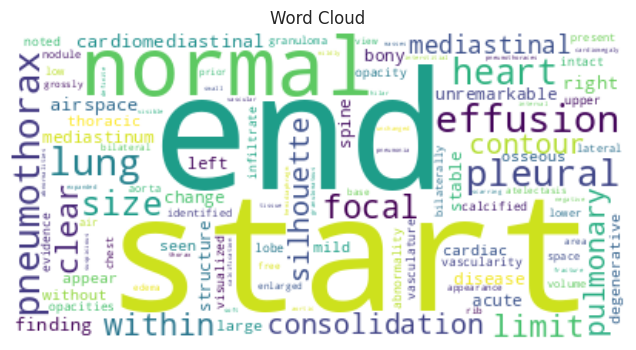

In [12]:
word_cloud = WordCloud(collocations=False,background_color='white').generate(" ".join(df_reports.CLEAN_FINDING.values.tolist()))
plt.figure(figsize=(8,4))
plt.title("Word Cloud")
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# Save Token Dictionary

In [13]:
token_dct = {'tokenizer':tokenizer,'vocabsize':VOCABSIZE,'seq_len':SEQ_LENGTH}
save_pkl(data=token_dct,filepath=os.path.join(models_filepath,"token_dct.pkl"))

file saved as  /content/drive/MyDrive/ChestXAI/models/token_dct.pkl


## Extract feature images & Create Final Dataset

In [14]:
df_reports = df_reports[["ID","CLEAN_FINDING"]].rename(columns={'CLEAN_FINDING':'FINDING'})
df_reports.head()

,ID,FINDING
0,CXR3745_IM-1872-1001,<start> cardiomediastinal silhouette pulmonary...
1,CXR3745_IM-1872-1002,<start> cardiomediastinal silhouette pulmonary...
2,CXR3726_IM-1862-1001,<start> heart size normal lungs clear normal n...
3,CXR3726_IM-1862-1002,<start> heart size normal lungs clear normal n...
4,CXR3731_IM-1865-1001,<start> lungs clear heart mediastinum appear n...


In [15]:
model_xception_fp = os.path.join(models_filepath,"xception.keras")
if not os.path.exists(model_xception_fp):
  model_xception = xception.Xception(include_top=False,weights='imagenet',pooling='avg',input_shape=(299,299,3))
  print("output shape:",model_xception.output_shape)
  model_xception_fp = os.path.join(models_filepath,"xception.keras")
  model_xception.save(model_xception_fp)
else:
  print(model_xception_fp," is already exist")
  model_xception = load_model(model_xception_fp,compile=False)

/content/drive/MyDrive/ChestXAI/models/xception.keras  is already exist


In [61]:
# Save Dataset
dataset_fp = os.path.join(dataset_filepath,"dataset.pkl")
if not os.path.exists(dataset_fp):
  df_reports["FEATURE"] = df_reports["ID"].apply(lambda row:extract_an_image_feature(model=model_xception,img_root_path=image_filepath,img_id=row))
  dataset = df_reports.copy() # IMG_ID, IMG REPORTS and IMG_FEATURES
  save_pkl(data=dataset,filepath=dataset_fp)
else:
  print(dataset_fp," is already exist.")
  dataset = load_pkl(dataset_fp)


dataset.sample(5)

/content/drive/MyDrive/ChestXAI/dataset/dataset.pkl  is already exist.
file load from  /content/drive/MyDrive/ChestXAI/dataset/dataset.pkl


,ID,FINDING,FEATURE
4888,CXR2419_IM-0963-2001,<start> no findings <end>,"[[0.46947524, 0.011917719, 0.32683918, 0.0, 0...."
1747,CXR948_IM-2443-2001,<start> heart top normal size mediastinum stab...,"[[0.509728, 0.2537169, 0.17621532, 0.021933718..."
2630,CXR3146_IM-1479-2001,<start> no focal lung consolidation heart size...,"[[0.28943133, 0.55097896, 0.17779437, 0.0, 0.0..."
3157,CXR3434_IM-1662-2001,<start> no findings <end>,"[[0.16780294, 0.04300176, 0.15421861, 0.0, 0.1..."
5164,CXR2563_IM-1066-1001,<start> cardiomediastinal silhouette pulmonary...,"[[0.12158933, 0.26531118, 0.2177902, 0.0, 0.02..."


# Load Tokenizer, Models, Dataset etc.

In [17]:
token_dct = load_pkl(os.path.join(models_filepath,"token_dct.pkl"))
tokenizer = token_dct.get("tokenizer")
SEQ_LENGTH = token_dct.get('seq_len')
VOCABSIZE = token_dct.get('vocabsize')

file load from  /content/drive/MyDrive/ChestXAI/models/token_dct.pkl


# Training with CNN + LSTM

In [13]:
# Dataset
from sklearn.model_selection import train_test_split

def split_data(dataset: pd.DataFrame, test_size: float) -> dict:
    finding_train,finding_test,feature_train,feature_test = train_test_split(dataset['FINDING'],dataset['FEATURE'],shuffle=True,random_state=42,test_size=test_size)
    feature_train = np.array([np.squeeze(feat) for feat in feature_train])
    feature_test = np.array([np.squeeze(feat) for feat in feature_test])

    dct = {'train': {'features': feature_train, 'sentences': finding_train},
            'test': {'features': feature_test, 'sentences': finding_test}}

    for k,v in dct.items():
      for k2,v2 in dct[k].items():
        print(f"Dataset {k} > {k2}.shape:{v2.shape}")
    return dct

def create_sequence_data(image_features:np.ndarray,image_findings:np.ndarray,tokenizer,seq_length:int,n_vocab:int):
    image_arr = []
    sequence_arr = []
    output_arr = []
    for img_feature,img_finding in zip(image_features,image_findings):
      curr_seq = tokenizer.texts_to_sequences([img_finding])[0]
      for idx in range(1,len(curr_seq)):
        in_seq = curr_seq[:idx]
        next_word = curr_seq[idx]

        in_seq = pad_sequences([in_seq],maxlen=seq_length)[0]
        out_seq = to_categorical([next_word],num_classes=n_vocab)[0]

      image_arr.append(img_feature)
      sequence_arr.append(in_seq)
      output_arr.append(out_seq)

    image_arr = np.array(image_arr)
    seq_arr = np.array(sequence_arr)
    out_arr = np.array(output_arr)
    return image_arr,seq_arr,out_arr

In [65]:
data = split_data(df=dataset,test_size=.2)

X_train_images,X_train_sentences,y_train = create_sequence_data(image_features=data["train"]["features"],
                                                                image_findings=data["train"]["sentences"],
                                                                tokenizer=tokenizer,
                                                                seq_length=SEQ_LENGTH,
                                                                n_vocab=VOCABSIZE)

X_test_images,X_test_sentences,y_test = create_sequence_data(image_features=data["test"]["features"],
                                                             image_findings=data["test"]["sentences"],
                                                             tokenizer=tokenizer,
                                                             seq_length=SEQ_LENGTH,
                                                             n_vocab=VOCABSIZE)

data = {'train':{'image_features':X_train_images,'findings':X_train_sentences,'outputs':y_train},
        'test':{'image_features':X_test_images,'findings':X_test_sentences,'outputs':y_test}}

Dataset train > features.shape:(5727, 2048)
Dataset train > sentences.shape:(5727,)
Dataset test > features.shape:(1432, 2048)
Dataset test > sentences.shape:(1432,)


In [9]:
from keras.utils import plot_model
from keras.models import Model
from keras import layers
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint

# Train
def define_model(n_vocab:int, sequence_length:int,save_model=True):
  # Encoder
  image_features_input = layers.Input(shape=(2048,),name="ImageInput")
  image_features_out = layers.Dropout(0.5)(image_features_input)
  image_features_out = layers.Dense(256, activation='relu',name="ImageFinal")(image_features_out)

  sequence_input = layers.Input(shape=(sequence_length,),name="SentenceInput")
  sequence_out = layers.Embedding(n_vocab, 256, mask_zero=True)(sequence_input)
  sequence_out = layers.Dropout(0.5)(sequence_out)
  sequence_out = layers.LSTM(256)(sequence_out)

  # Decoder
  decoder_out = layers.concatenate([image_features_out, sequence_out],axis=1)
  decoder_out = layers.Dense(256, activation='relu')(decoder_out)
  outputs = layers.Dense(n_vocab, activation='softmax')(decoder_out)

  model = Model(inputs=[image_features_input, sequence_input], outputs=outputs)
  optim = Adam(lr=1e-4)
  model.compile(loss='categorical_crossentropy', optimizer=optim)

  # summarize model
  print(model.summary())
  return model

def train(data:dict,model_filepath:str,n_vocab:int,sequence_length:int,epochs=5,batch_size=128):
  print("Training...")
  data_train, data_test = data["train"], data["test"]

  X_train_image, X_train_finding = np.squeeze(data_train["image_features"]),data_train["findings"]
  y_train = data_train["outputs"]

  X_test_image,X_test_finding = np.squeeze(data_test["image_features"]),data_test["findings"]
  y_test = data_test["outputs"]

  model = define_model(n_vocab=n_vocab,sequence_length=sequence_length)
  model_filepath =  os.path.join(model_filepath,'model-ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5')
  checkpoint = ModelCheckpoint(model_filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
  model.fit([X_train_image, X_train_finding], y_train, epochs=epochs, batch_size=batch_size,
            validation_data=([X_test_image, X_test_finding], y_test),callbacks=[checkpoint])

In [68]:
train(data=data,model_filepath=models_filepath,n_vocab=VOCABSIZE,sequence_length=SEQ_LENGTH,epochs=5,batch_size=64)

Training...


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 SentenceInput (InputLayer)  [(None, 40)]                 0         []                            
                                                                                                  
 ImageInput (InputLayer)     [(None, 2048)]               0         []                            
                                                                                                  
 embedding_2 (Embedding)     (None, 40, 256)              355328    ['SentenceInput[0][0]']       
                                                                                                  
 dropout_4 (Dropout)         (None, 2048)                 0         ['ImageInput[0][0]']          
                                                                                            

# Training with Self-Attention from Scratch

In [20]:
# Model
class PositionEncoder:
    def calculate_angle(self, pos, i, embed_dim):
        aci_orani = 1 / np.power(10000, (2 * (i // 2)) / np.float32(embed_dim))
        return pos * aci_orani

    def to_decoder(self, pos, embed_dim):
        aci_orani = self.calculate_angle(np.arange(pos)[:, np.newaxis], np.arange(embed_dim)[np.newaxis, :], embed_dim)

        aci_orani[:, 0::2] = np.sin(aci_orani[:, 0::2])
        aci_orani[:, 1::2] = np.cos(aci_orani[:, 1::2])
        pos_encoding = aci_orani[np.newaxis, ...]
        return tf.cast(pos_encoding, dtype=tf.float32)

    def to_encoder(self, satir, sutun, embed_dim):
        assert embed_dim % 2 == 0
        satir_pos = np.repeat(np.arange(satir), sutun)[:, np.newaxis]
        sutun_pos = np.repeat(np.expand_dims(np.arange(sutun), 0), satir, axis=0).reshape(-1, 1)

        aci_orani_satir = self.calculate_angle(satir_pos, np.arange(embed_dim // 2)[np.newaxis, :], embed_dim // 2)
        aci_orani_sutun = self.calculate_angle(sutun_pos, np.arange(embed_dim // 2)[np.newaxis, :], embed_dim // 2)

        aci_orani_satir[:, 0::2] = np.sin(aci_orani_satir[:, 0::2])
        aci_orani_satir[:, 1::2] = np.cos(aci_orani_satir[:, 1::2])
        aci_orani_sutun[:, 0::2] = np.sin(aci_orani_sutun[:, 0::2])
        aci_orani_sutun[:, 1::2] = np.cos(aci_orani_sutun[:, 1::2])
        pos_encoding = np.concatenate([aci_orani_satir, aci_orani_sutun], axis=1)[np.newaxis, ...]
        return tf.cast(pos_encoding, dtype=tf.float32)


# Scaled dot product [q*k / sqrt(dk)] * v
def scaled_dot_product_attention(q, k, v, mask):
    matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)
    dimension_of_k = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dimension_of_k)
    if mask is not None:
        scaled_attention_logits += (mask * -1e9)

    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)
    output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

    return output, attention_weights


class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, embed_dim, nheads):
        super(MultiHeadAttention, self).__init__()
        self.nheads = nheads
        self.embed_dim = embed_dim
        assert embed_dim % self.nheads == 0
        self.depth = embed_dim // self.nheads
        self.wq = tf.keras.layers.Dense(embed_dim)
        self.wk = tf.keras.layers.Dense(embed_dim)
        self.wv = tf.keras.layers.Dense(embed_dim)
        self.dense = tf.keras.layers.Dense(embed_dim)

    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.nheads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, v, k, q, mask=None):
        batch_size = tf.shape(q)[0]
        q = self.wq(q)  # (batch_size, seq_len, embed_dim)
        k = self.wk(k)  # (batch_size, seq_len, embed_dim)
        v = self.wv(v)  # (batch_size, seq_len, embed_dim)

        q = self.split_heads(q, batch_size)  # (batch_size, nheads, seq_len_q, depth)
        k = self.split_heads(k, batch_size)  # (batch_size, nheads, seq_len_k, depth)
        v = self.split_heads(v, batch_size)  # (batch_size, nheads, seq_len_v, depth)

        scaled_attention, attention_weights = scaled_dot_product_attention(q, k, v, mask)
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, nheads, depth)

        concat_attention = tf.reshape(scaled_attention,
                                      (batch_size, -1, self.embed_dim))  # (batch_size, seq_len_q, embed_dim)

        output = self.dense(concat_attention)  # (batch_size, seq_len_q, embed_dim)
        return output, attention_weights


def point_wise_feed_forward_network(embed_dim, ffn_dim):
    return tf.keras.Sequential([tf.keras.layers.Dense(ffn_dim, activation='relu'),
                                tf.keras.layers.Dense(embed_dim)])  # (batch_size, seq_len, embed_dim)])


class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ffn_dim, rate=0.1):
        super(EncoderLayer, self).__init__()
        self.mha = MultiHeadAttention(embed_dim, num_heads)  # multi head attention
        self.ffn = point_wise_feed_forward_network(embed_dim, ffn_dim)  # Feed forward network

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)

    def call(self, x, training, mask=None):
        attn_output, _ = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, embed_dim)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, embed_dim)
        ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, embed_dim)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, embed_dim)
        return out2


class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, embed_dim, nheads, ffn_dim, rate=0.1):
        super(DecoderLayer, self).__init__()
        self.mha1 = MultiHeadAttention(embed_dim, nheads)
        self.mha2 = MultiHeadAttention(embed_dim, nheads)

        self.ffn = point_wise_feed_forward_network(embed_dim, ffn_dim)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        self.dropout3 = tf.keras.layers.Dropout(rate)

    def call(self, x, enc_output, training, look_ahead_mask=None, padding_mask=None):
        attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)  # (batch_size, target_seq_len, embed_dim)
        attn1 = self.dropout1(attn1, training=training)
        out1 = self.layernorm1(attn1 + x)

        attn2, attn_weights_block2 = self.mha2(enc_output, enc_output, out1, padding_mask)
        attn2 = self.dropout2(attn2, training=training)
        out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, embed_dim)

        ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, embed_dim)
        ffn_output = self.dropout3(ffn_output, training=training)
        out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, embed_dim)

        return out3, attn_weights_block1, attn_weights_block2


class Encoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, embed_dim, nheads, ffn_dim, row_size, col_size, rate=0.1):
        super(Encoder, self).__init__()
        self.embed_dim = embed_dim
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Dense(self.embed_dim, activation='relu')
        self.pos_encoding = PositionEncoder().to_encoder(row_size, col_size, self.embed_dim)

        self.enc_layers = [EncoderLayer(embed_dim, nheads, ffn_dim, rate) for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)

    def call(self, x, training, mask=None):
        print("X.shape:",x.shape)
        print("tf.shape(X):",tf.shape(x))
        print("tf.shape(X):",tf.shape(x)[0])
        print("tf.shape(X):",tf.shape(x)[1])
        seq_len = tf.shape(x)[1]
        x = self.embedding(x)  # (batch_size, input_seq_len(H*W), embed_dim)
        x += self.pos_encoding[:, :seq_len, :]
        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training, mask)

        return x  # (batch_size, input_seq_len, embed_dim)


class Decoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, embed_dim, nheads, ffn_dim, vocabsize, rate=0.1):
        super(Decoder, self).__init__()
        self.embed_dim = embed_dim
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(vocabsize, embed_dim)
        self.pos_encoding = PositionEncoder().to_decoder(vocabsize, embed_dim)

        self.dec_layers = [DecoderLayer(embed_dim, nheads, ffn_dim, rate) for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)

    def call(self, x, enc_output, training, look_ahead_mask=None, padding_mask=None):
        seq_len = tf.shape(x)[1]
        attention_weights = {}

        x = self.embedding(x)  # (batch_size, target_seq_len, embed_dim)
        x *= tf.math.sqrt(tf.cast(self.embed_dim, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]
        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x, block1, block2 = self.dec_layers[i](x, enc_output, training, look_ahead_mask, padding_mask)

            attention_weights['decoder_layer{}_block1'.format(i + 1)] = block1
            attention_weights['decoder_layer{}_block2'.format(i + 1)] = block2

        return x, attention_weights


@tf.keras.saving.register_keras_serializable('my_package')
class Transformer(tf.keras.models.Model):
    def __init__(self, num_layers, embed_dim, nheads, ffn_dim, row_size, col_size, vocabsize, rate=0.1):
        super(Transformer, self).__init__()
        self.encoder = Encoder(num_layers, embed_dim, nheads, ffn_dim, row_size, col_size, rate)
        self.decoder = Decoder(num_layers, embed_dim, nheads, ffn_dim, vocabsize, rate)
        self.final_layer = tf.keras.layers.Dense(vocabsize)

    def call(self, inp, tar, training, look_ahead_mask=None, dec_padding_mask=None, enc_padding_mask=None):
        enc_output = self.encoder(inp, training, enc_padding_mask)  # (batch_size, inp_seq_len, embed_dim  )
        dec_output, attention_weights = self.decoder(tar, enc_output, training, look_ahead_mask, dec_padding_mask)
        final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, vocabsize)
        return final_output, attention_weights


In [70]:
# Dataset
features = dataset["FEATURE"].values
captions_sequences = tokenizer.texts_to_sequences(dataset["FINDING"].values)
captions =  pad_sequences(captions_sequences, padding='post')

train_image_features, test_image_features, train_captions, test_captions = train_test_split(features,captions,test_size=0.1,random_state=17)
train_image_features = tf.ragged.constant(train_image_features).to_tensor()
test_image_features = tf.ragged.constant(test_image_features).to_tensor()
train_captions =  tf.ragged.constant(train_captions).to_tensor()
test_captions = tf.ragged.constant(test_captions).to_tensor()

BATCH_SIZE = 64
train_dataset = tf.data.Dataset.from_tensor_slices((train_image_features,train_captions)).batch(BATCH_SIZE)
test_dataset = tf.data.Dataset.from_tensor_slices((test_image_features,test_captions)).batch(BATCH_SIZE)
print("Train Image Shapes:",train_image_features.shape)
print("Test Image Shapes:",test_image_features.shape)
print("Train Captions Shapes:",train_captions.shape)
print("Test Captions Shapes:",test_captions.shape)

Train Image Shapes: (6443, 1, 2048)
Test Image Shapes: (716, 1, 2048)
Train Captions Shapes: (6443, 40)
Test Captions Shapes: (716, 40)


In [18]:
# Define Custom Learning Rate Scheduler, Loss Function & Mask Decoder
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, embed_dim, warmup_steps=4000):
        super(CustomSchedule, self).__init__()
        self.embed_dim = embed_dim
        self.embed_dim = tf.cast(self.embed_dim, tf.float32)
        self.warmup_steps = warmup_steps

    def __call__(self, step):
        arg1 = tf.math.rsqrt(float(step))
        arg2 = float(step) * (self.warmup_steps ** -1.5)
        v_min = tf.math.minimum(arg1,arg2)
        out = tf.math.rsqrt(self.embed_dim) * v_min
        return out

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

def create_masks_decoder(seq):
    mask_size = tf.shape(seq)[1]
    look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((mask_size, mask_size)), -1, 0)
    dec_target_padding_mask = tf.cast(tf.math.equal(seq, 0), tf.float32)[:, tf.newaxis, tf.newaxis, :]
    combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)
    return combined_mask

In [72]:
# Train

NUM_LAYER = 8 # encoder-decoder blok tekrar sayısı
EMBED_DIM = 512 # embedding dimension
FFN_DIM = 4096 #feed-forward network dimension
NHEADS = 8 # kafa sayısı
ROW_SIZE = 8 # encoder-input- hizalama satir sayisi
COL_SIZE = 8 # encoder-input- hizalama sutun sayisi
DROPOUT_RATE = 0.1 # dropout oranı
EPOCHS = 10

learning_rate = CustomSchedule(EMBED_DIM)
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.98,epsilon=1e-9)
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')
transformer = Transformer(NUM_LAYER,EMBED_DIM,NHEADS,FFN_DIM,ROW_SIZE,COL_SIZE,VOCABSIZE,rate=DROPOUT_RATE)



@tf.function
def train_step(img_tensor, seq):
    seq_inp = seq[:, :-1]
    seq_real = seq[:, 1:]
    decoder_mask = create_masks_decoder(seq_inp)
    with tf.GradientTape() as tape:
        predictions, _ = transformer(img_tensor, seq_inp,True, decoder_mask)
        loss = loss_function(seq_real, predictions)

    gradients = tape.gradient(loss, transformer.trainable_variables)
    optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))
    train_loss(loss)
    train_accuracy(seq_real, predictions)


losses = []
print(f"Training started! >> EPOCHS:{EPOCHS} \t BATCH_SIZE:{BATCH_SIZE}\n---\n")
for epoch in range(EPOCHS):
    start = time.time()
    train_loss.reset_states()
    train_accuracy.reset_states()
    for (batch, (img_tensor, seq)) in enumerate(train_dataset):
        train_step(img_tensor, seq)
        if batch % 32 == 0:
            print ('Epoch {} Batch {} Loss {:.4f} Accuracy {:.4f}'.format(epoch + 1, batch, train_loss.result(), train_accuracy.result()))
    losses.append(train_loss.result())
    print("---------------------------------------------------------------")
    print ('Epoch {} Loss {:.4f} Accuracy {:.4f}'.format(epoch + 1,train_loss.result(),train_accuracy.result()))
    print ('Time taken for 1 epoch: {} secs'.format(time.time() - start))
    print("\n===============================================================\n")

Training started! >> EPOCHS:10 	 BATCH_SIZE:64
---

Epoch 1 Batch 0 Loss 7.5284 Accuracy 0.0000
Epoch 1 Batch 32 Loss 7.0135 Accuracy 0.0115
Epoch 1 Batch 64 Loss 6.4895 Accuracy 0.0205
Epoch 1 Batch 96 Loss 6.1911 Accuracy 0.0235
---------------------------------------------------------------
Epoch 1 Loss 6.1619 Accuracy 0.0238
Time taken for 1 epoch: 182.41856384277344 secs


Epoch 2 Batch 0 Loss 5.4808 Accuracy 0.0325
Epoch 2 Batch 32 Loss 5.3423 Accuracy 0.0304
Epoch 2 Batch 64 Loss 5.2471 Accuracy 0.0342
Epoch 2 Batch 96 Loss 5.1323 Accuracy 0.0387
---------------------------------------------------------------
Epoch 2 Loss 5.1165 Accuracy 0.0392
Time taken for 1 epoch: 162.83064913749695 secs


Epoch 3 Batch 0 Loss 4.7939 Accuracy 0.0557
Epoch 3 Batch 32 Loss 4.6065 Accuracy 0.0640
Epoch 3 Batch 64 Loss 4.4801 Accuracy 0.0778
Epoch 3 Batch 96 Loss 4.3083 Accuracy 0.0930
---------------------------------------------------------------
Epoch 3 Loss 4.2840 Accuracy 0.0949
Time taken 

In [73]:
# Save Model
transformer.save(os.path.join(models_filepath,'predictor.tf'),save_format='tf')

# Test

In [14]:
token_dct = load_pkl(os.path.join(models_filepath,"token_dct.pkl"))
tokenizer = token_dct.get("tokenizer")
SEQ_LENGTH = token_dct.get('seq_len')
VOCABSIZE = token_dct.get('vocabsize')

model_xception = load_model(os.path.join(models_filepath,'xception.keras'))
dataset = split_data(load_pkl(os.path.join(dataset_filepath,'dataset.pkl')),test_size=.9)
basic_model = load_model(os.path.join(models_filepath,'basic_model.h5'),compile=False)
transformer_model = load_model(os.path.join(models_filepath,'predictor.tf'),compile=False)

file load from  /content/drive/MyDrive/ChestXAI/models/token_dct.pkl
file load from  /content/drive/MyDrive/ChestXAI/dataset/dataset.pkl
Dataset train > features.shape:(715, 2048)
Dataset train > sentences.shape:(715,)
Dataset test > features.shape:(6444, 2048)
Dataset test > sentences.shape:(6444,)


In [15]:
idx = 0
sample_img_feature = dataset["test"]["features"][idx]
sample_img_sentence = dataset["test"]["sentences"][idx]
print("Sentence:",sample_img_sentence)

Sentence: <start> cardiomediastinal silhouette pulmonary vasculature within normal limits lungs clear no pneumothorax pleural effusion no acute osseous findings <end>


In [22]:
transformer_model = load_model(os.path.join(models_filepath,'predictor.tf'),compile=False)

In [23]:
def generate_caption(img_features, model, tokenizer, seq_length=40) -> str:
    start_token = tokenizer.word_index['start']
    end_token = tokenizer.word_index['end']
    decoder_input = [start_token]
    output = tf.expand_dims(decoder_input, 0)  # tokens
    result = []  # word list
    print("Output.shape:",output.shape)
    for i in range(seq_length):
        dec_mask = create_masks_decoder(output)
        predictions, attention_weights = model(img_features, output, False, dec_mask)
        predictions = predictions[:, -1:, :]  # (batch_size, 1, vocab_size)
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)
        if predicted_id == end_token:
            caption = ' '.join(result).replace('start','').replace('end','.')
            return caption

        result.append(tokenizer.index_word[int(predicted_id)])  # prediction as words
        output = tf.concat([output, predicted_id], axis=-1)  # prediction as indexes

    # caption, tf.squeeze(output, axis=0), attention_weights
    caption = ' '.join(result).replace('start', '').replace('end', '.')
    return caption